In [63]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from scipy.stats import kurtosis
from scipy.stats import skew
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

%matplotlib inline

In [3]:
loan = pd.read_csv(os.path.abspath(os.path.join(os.getcwd(), 'data\\train_loanpred.csv')))
loan.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0,141.0,360.0,1.0,Urban,Y


In [4]:
loan.shape

(614, 13)

In [5]:
loan.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome      int64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [6]:
missing_val = loan.isna().sum().sort_values(ascending=False)
missing_val

Credit_History       50
Self_Employed        32
LoanAmount           22
Dependents           15
Loan_Amount_Term     14
Gender               13
Married               3
Loan_ID               0
Education             0
ApplicantIncome       0
CoapplicantIncome     0
Property_Area         0
Loan_Status           0
dtype: int64

In [7]:
missing_pct = round(missing_val[missing_val > 0]/loan.shape[0]  * 100, 2)
missing_pct.apply(lambda x: f'{str(x)}%')

Credit_History      8.14%
Self_Employed       5.21%
LoanAmount          3.58%
Dependents          2.44%
Loan_Amount_Term    2.28%
Gender              2.12%
Married             0.49%
dtype: object

In [8]:
#print rows with Nan
loan[loan.isnull().any(axis=1)]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0,NaN,360.0,1.0,Urban,Y
11,LP001027,Male,Yes,2,Graduate,NaN,2500,1840,109.0,360.0,1.0,Urban,Y
16,LP001034,Male,No,1,Not Graduate,No,3596,0,100.0,240.0,NaN,Urban,Y
19,LP001041,Male,Yes,0,Graduate,NaN,2600,3500,115.0,NaN,1.0,Urban,Y
23,LP001050,NaN,Yes,2,Not Graduate,No,3365,1917,112.0,360.0,0.0,Rural,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,LP002933,NaN,No,3+,Graduate,Yes,9357,0,292.0,360.0,1.0,Semiurban,Y
597,LP002943,Male,No,NaN,Graduate,No,2987,0,88.0,360.0,0.0,Semiurban,N
600,LP002949,Female,No,3+,Graduate,NaN,416,41667,350.0,180.0,NaN,Urban,N
601,LP002950,Male,Yes,0,Not Graduate,NaN,2894,2792,155.0,360.0,1.0,Rural,Y


## Numeric variable analysis

In [9]:
loan.describe().T

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.00,81000.0
CoapplicantIncome,614.0,1621.244300,2926.248760,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,592.0,146.412162,85.587325,9.0,100.0,128.0,168.00,700.0
Loan_Amount_Term,600.0,342.000000,65.120410,12.0,360.0,360.0,360.00,480.0
Credit_History,564.0,0.842199,0.364878,0.0,1.0,1.0,1.00,1.0


<Axes: xlabel='LoanAmount', ylabel='Count'>

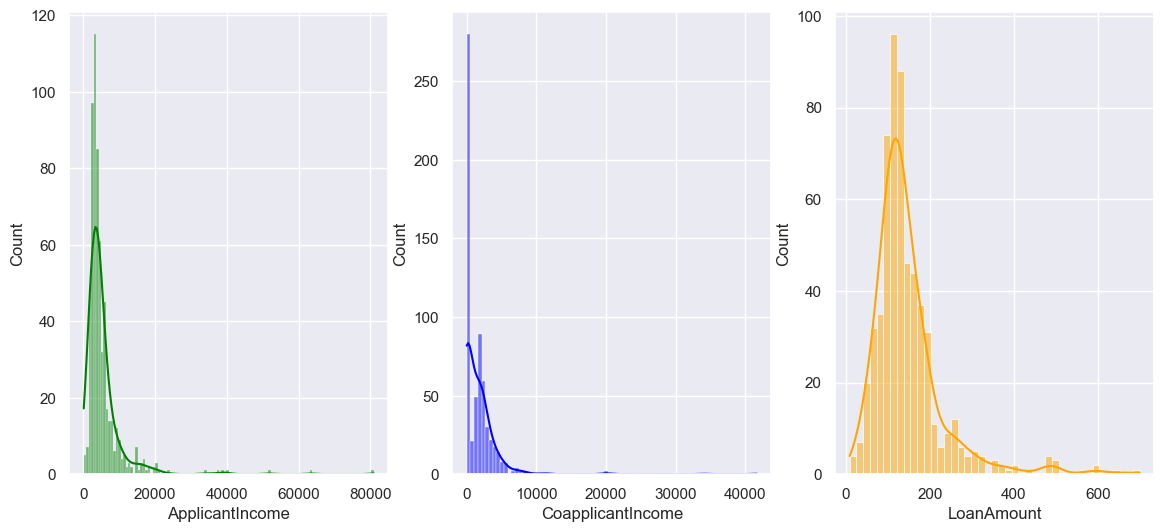

In [10]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(1, 3, figsize=(14, 6))

sns.histplot(data=loan, x="ApplicantIncome", kde=True, ax=ax[0], color='green')
sns.histplot(data=loan, x="CoapplicantIncome", kde=True, ax=ax[1], color='blue')
sns.histplot(data=loan, x="LoanAmount", kde=True, ax=ax[2], color='orange')

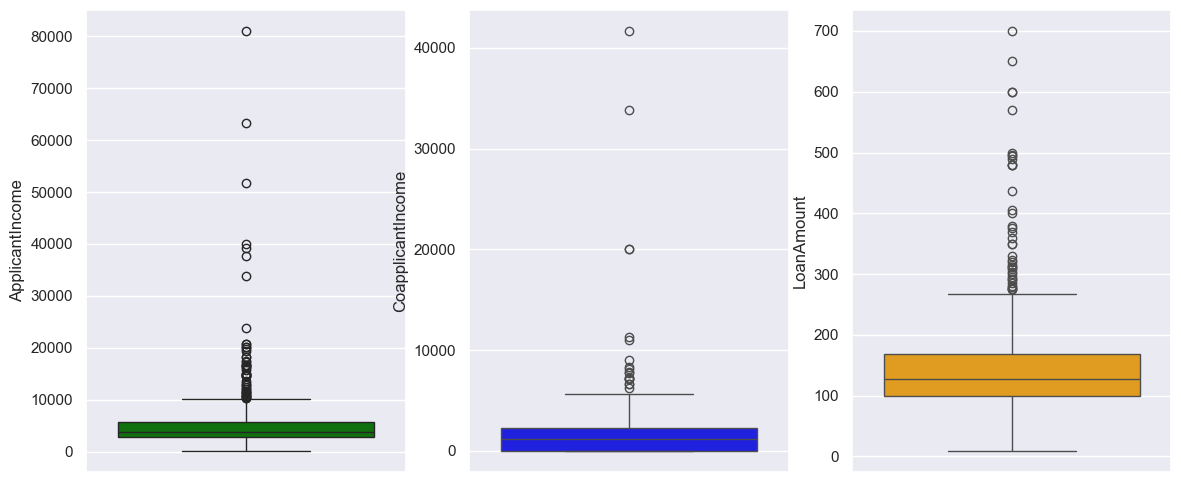

In [11]:
#Check for outliers in numeric variables
fig, ax = plt.subplots(1, 3, figsize=(14, 6))

sns.boxplot(data=loan, y="ApplicantIncome", ax=ax[0], color='green')
sns.boxplot(data=loan, y="CoapplicantIncome", ax=ax[1], color='blue')
sns.boxplot(data=loan, y="LoanAmount", ax=ax[2], color='orange');

In [12]:
def iqr(df:pd.DataFrame, column:str):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

def analyze_numerical(df, numeric_cols):
    data = []
    for col in numeric_cols:
        outliers = iqr(df, col) 
        data.append({"column": col, 
                 "missing": df[col].isna().sum(), 
                 "outliers": len(outliers), 
                 "skew": skew(df[col])
                })
    num_df = pd.DataFrame(data)
    return num_df

In [13]:
numeric_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
analyze_numerical(loan, numeric_cols)

,column,missing,outliers,skew
0,ApplicantIncome,0,50,6.523526
1,CoapplicantIncome,0,18,7.473215
2,LoanAmount,22,39,NaN


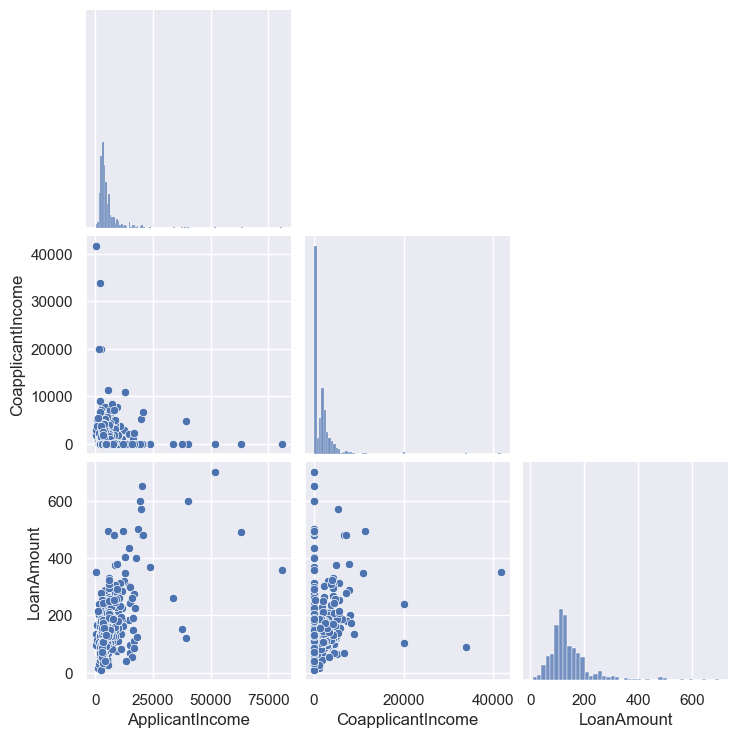

In [14]:
#numeric vs numeric relationship
sns.pairplot(loan[numeric_cols], corner=True)

In [15]:
#numerical outliers vs target
applicant_outliers = iqr(loan, numeric_cols[0])
loan_outliers = loan.copy()
loan_outliers["ApplicantIncome_Flag"] = np.where(loan_outliers.index.isin(applicant_outliers.index), 1, 0)
pd.crosstab(loan_outliers['ApplicantIncome_Flag'], loan_outliers["Loan_Status"], normalize='index')

Loan_Status,N,Y
ApplicantIncome_Flag,,
0,0.310284,0.689716
1,0.340000,0.660000


Text(0.5, 1.0, 'Distribution of Target Variable by Outlier Status')

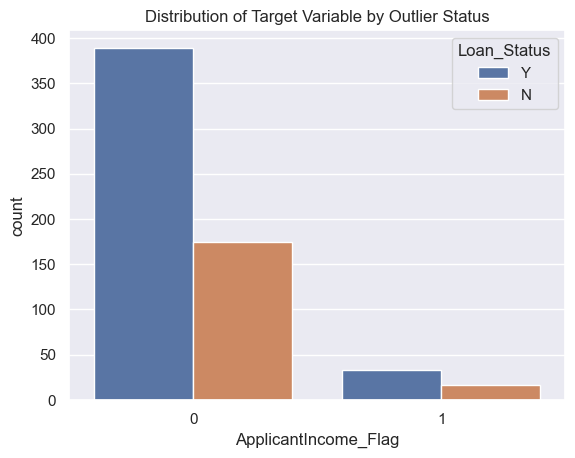

In [16]:
sns.countplot(x=loan_outliers['ApplicantIncome_Flag'], hue=loan_outliers["Loan_Status"])
plt.title("Distribution of Target Variable by Outlier Status")

In [17]:
contingency_table = pd.crosstab(loan_outliers['ApplicantIncome_Flag'], loan_outliers["Loan_Status"])
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2}, P-value: {p}")
#If p < 0.05, outliers significantly impact the target distribution. Here, no impact so we can transform the outliers

Chi-Square Statistic: 0.07576953558283761, P-value: 0.7831144447291886


In [18]:
co_applicant_outliers = iqr(loan, numeric_cols[1])
loan_outliers_coapp = loan.copy()
loan_outliers_coapp["CoApplicantIncome_Flag"] = np.where(loan_outliers_coapp.index.isin(co_applicant_outliers.index), 1, 0)
pd.crosstab(loan_outliers_coapp['CoApplicantIncome_Flag'], loan_outliers_coapp["Loan_Status"], normalize='index')

Loan_Status,N,Y
CoApplicantIncome_Flag,,
0,0.308725,0.691275
1,0.444444,0.555556


In [19]:
contingency_table = pd.crosstab(loan_outliers_coapp['CoApplicantIncome_Flag'], loan_outliers_coapp["Loan_Status"])
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2}, P-value: {p}")

Chi-Square Statistic: 0.9325582833357189, P-value: 0.33419903791904465


In [20]:
loan_amt_outliers = iqr(loan, numeric_cols[2])
loan_outliers_amt = loan.copy()
loan_outliers_amt["LoanAmount_Flag"] = np.where(loan_outliers_amt.index.isin(loan_amt_outliers.index), 1, 0)
pd.crosstab(loan_outliers_amt['LoanAmount_Flag'], loan_outliers_amt["Loan_Status"], normalize='index')

Loan_Status,N,Y
LoanAmount_Flag,,
0,0.307826,0.692174
1,0.384615,0.615385


In [21]:
contingency_table = pd.crosstab(loan_outliers_amt['LoanAmount_Flag'], loan_outliers_amt["Loan_Status"])
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2}, P-value: {p}")

Chi-Square Statistic: 0.6766048701481684, P-value: 0.4107582821654169


In [22]:
numeric_pipeline = Pipeline(steps=[
    ("impute", SimpleImputer(missing_values=np.nan, strategy='median')),
    ("log1p", FunctionTransformer(np.log1p, validate=True))

])

numeric_transforms = ColumnTransformer(transformers=[
    ("numeric_pipeline", numeric_pipeline, numeric_cols),
])

numeric_transforms

ColumnTransformer(transformers=[('numeric_pipeline',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('log1p',
                                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                                      validate=True))]),
                                 ['ApplicantIncome', 'CoapplicantIncome',
                                  'LoanAmount'])])

In [23]:
numeric_transformed = numeric_transforms.fit_transform(loan[numeric_cols])
numeric_transformed_df = pd.DataFrame(numeric_transformed, columns=numeric_cols, index=loan.index)
numeric_transformed_df

,ApplicantIncome,CoapplicantIncome,LoanAmount
0,8.674197,0.000000,4.859812
1,8.430327,7.319202,4.859812
2,8.006701,0.000000,4.204693
3,7.857094,7.765993,4.795791
4,8.699681,0.000000,4.955827
...,...,...,...
609,7.972811,0.000000,4.276666
610,8.320448,0.000000,3.713572
611,8.996280,5.484797,5.537334
612,8.933796,0.000000,5.236442


In [24]:
#after EDA
analyze_numerical(numeric_transformed_df, numeric_cols)

,column,missing,outliers,skew
0,ApplicantIncome,0,27,0.480949
1,CoapplicantIncome,0,0,-0.172642
2,LoanAmount,0,39,-0.151207


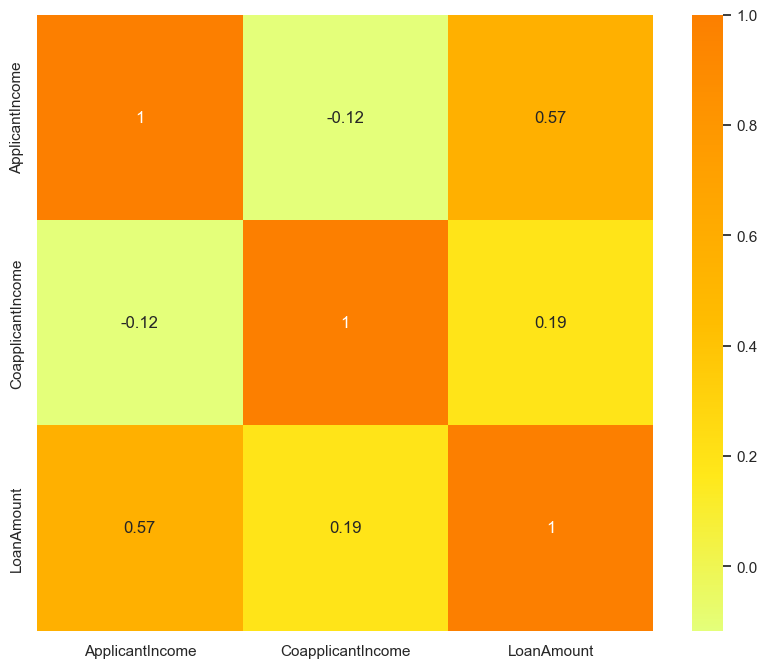

In [25]:
#numerical vs numerical 
corr = loan[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr ,cmap = 'Wistia', annot=True, square=True)
plt.show()

## Categorical variable analysis

In [26]:
#drop unwanted column
loan.drop(columns=['Loan_ID'], axis=1, inplace=True)

In [27]:
#convert Loan_Amount_Term to category
loan["Loan_Amount_Term"] = loan["Loan_Amount_Term"].astype('category')

In [28]:
cat = loan.select_dtypes(include=['object', 'category']).columns
cat_cols = cat.drop("Loan_Status").values
cat_cols

array(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Loan_Amount_Term', 'Property_Area'], dtype=object)

In [29]:
print(loan['Gender'].value_counts())  # Absolute counts
print(loan['Gender'].value_counts(normalize=True))  # Relative frequencies (%)

Gender
Male      489
Female    112
Name: count, dtype: int64
Gender
Male      0.813644
Female    0.186356
Name: proportion, dtype: float64


<Axes: xlabel='percent', ylabel='Property_Area'>

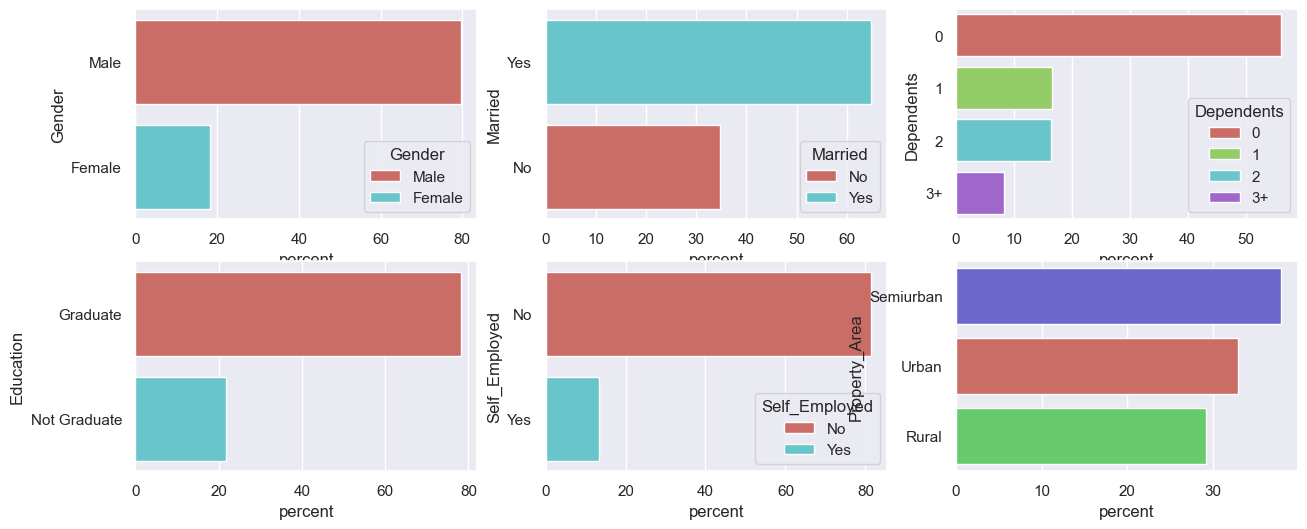

In [30]:
#check categorical distribution and outliers
fig, ax = plt.subplots(2,3, figsize=(15, 6))
sns.countplot(y=loan['Gender'], order=loan['Gender'].value_counts().index, hue=loan['Gender'], stat='percent', palette='hls', ax=ax[0,0])
sns.countplot(y=loan['Married'], order=loan['Married'].value_counts().index, hue=loan['Married'], stat='percent', palette='hls', ax=ax[0,1]) 
sns.countplot(y=loan['Dependents'], order=loan['Dependents'].value_counts().index, hue=loan['Dependents'], stat='percent', palette='hls', ax=ax[0,2]) 
sns.countplot(y=loan['Education'], order=loan['Education'].value_counts().index, hue=loan['Education'], stat='percent', palette='hls', ax=ax[1,0]) 
sns.countplot(y=loan['Self_Employed'], order=loan['Self_Employed'].value_counts().index, hue=loan['Self_Employed'], palette='hls', stat='percent', ax=ax[1,1]) 
sns.countplot(y=loan['Property_Area'], order=loan['Property_Area'].value_counts().index, hue=loan['Property_Area'], palette='hls', stat='percent', ax=ax[1,2]) 


<Axes: xlabel='Loan_Amount_Term', ylabel='count'>

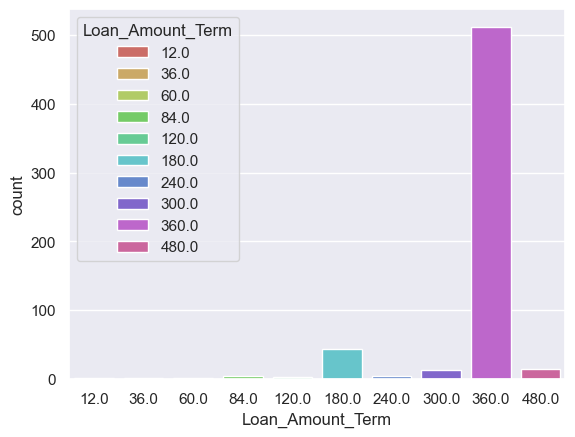

In [31]:
#discrete value analysis
sns.countplot(x=loan["Loan_Amount_Term"], hue= loan["Loan_Amount_Term"],  palette='hls')

In [32]:
#cat vs cat relationship analysis - chi squared
from itertools import product

cat_var_prod = list(product(cat_cols,cat_cols, repeat = 1))

df_cat = loan[cat_cols]
result = []
for i in cat_var_prod:
    if i[0] != i[1]:
        result.append((i[0],i[1],list(chi2_contingency(pd.crosstab(df_cat[i[0]], df_cat[i[1]])))[1]))

chi_test_output = pd.DataFrame(result, columns = ['var1', 'var2', 'p-val'])
chi_test_output.pivot(index='var1', columns='var2', values='p-val')

var2,Dependents,Education,Gender,Loan_Amount_Term,Married,Property_Area,Self_Employed
var1,,,,,,,
Dependents,NaN,0.472473,2.409881e-04,0.135798,1.178581e-17,0.314098,0.104556
Education,4.724732e-01,NaN,2.795190e-01,0.304680,8.033654e-01,0.158031,0.877840
Gender,2.409881e-04,0.279519,NaN,0.482415,4.324706e-19,0.018023,0.938809
Loan_Amount_Term,1.357982e-01,0.304680,4.824146e-01,NaN,3.129547e-02,0.118147,0.739756
Married,1.178581e-17,0.803365,4.324706e-19,0.031295,NaN,0.992893,1.000000
Property_Area,3.140983e-01,0.158031,1.802317e-02,0.118147,9.928935e-01,NaN,0.748146
Self_Employed,1.045560e-01,0.877840,9.388089e-01,0.739756,1.000000e+00,0.748146,NaN


In [33]:
#check correlation between cat variables - cramer's_v
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

for i in cat_var_prod:
    if i[0] != i[1]:
        print(f'{i} - {cramers_v(loan[i[0]], loan[i[1]])}')

('Gender', 'Married') - 0.365106746038068
('Gender', 'Dependents') - 0.18131561789217351
('Gender', 'Education') - 0.04411125015758613
('Gender', 'Self_Employed') - 0.0032182411222942305
('Gender', 'Loan_Amount_Term') - 0.12049738922777065
('Gender', 'Property_Area') - 0.11560586155657229
('Married', 'Gender') - 0.365106746038068
('Married', 'Dependents') - 0.36985225381386394
('Married', 'Education') - 0.010073217908373032
('Married', 'Self_Employed') - 0.0
('Married', 'Loan_Amount_Term') - 0.175332541618809
('Married', 'Property_Area') - 0.004831662947224027
('Dependents', 'Gender') - 0.1813156178921735
('Dependents', 'Married') - 0.369852253813864
('Dependents', 'Education') - 0.06480520720348182
('Dependents', 'Self_Employed') - 0.1041431434788516
('Dependents', 'Loan_Amount_Term') - 0.14134524658061612
('Dependents', 'Property_Area') - 0.07684055876005112
('Education', 'Gender') - 0.04411125015758613
('Education', 'Married') - 0.010073217908373034
('Education', 'Dependents') - 0.0

In [34]:
from sklearn.base import BaseEstimator, TransformerMixin


class SimpleImputerWithMapping(BaseEstimator, TransformerMixin):
    def __init__(self, mapping, target_col, reference_col):
        self.mapping = mapping  
        self.target_col = target_col 
        self.reference_col = reference_col
    
    def fit(self, X, y=None):
        return self  # No training needed, just a transformation
    
    def transform(self, X):
        X = X.copy() 
        missing_idx = X[X[self.target_col].isnull()].index 
        X.loc[missing_idx, self.target_col] = X.loc[missing_idx, self.reference_col].map(self.mapping)
        return X



class CustomBinning(BaseEstimator, TransformerMixin):
    def __init__(self, target_col):
        self.target_col = target_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X_new = pd.cut(X[self.target_col], bins=[0, 150, 300, 500], labels=['Short', 'Medium', 'Long'])
        #X = pd.concat([X.drop(self.target_col, axis=1), X_new], axis=1)
        X[self.target_col] = X_new
        return X


class DataFrameConverter(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return pd.DataFrame(X, columns=self.feature_names)

mapping = {"Graduate":"No", "Not Graduate": "Yes" }

cat_impute = Pipeline(steps=[
    ("custom_imputer", SimpleImputerWithMapping(mapping, target_col="Self_Employed", reference_col="Education")),
    ("custom_binning", CustomBinning(target_col="Loan_Amount_Term")),
    ("mode_impute", SimpleImputer(missing_values=np.nan, strategy='most_frequent')) 
])


cat_transforms = ColumnTransformer(transformers=[
    ("cat_impute", cat_impute, cat_cols)
], remainder='passthrough')

one_hot = ColumnTransformer(transformers=[
     ("ohe", OneHotEncoder(handle_unknown="error", drop="first", sparse_output=False), cat_cols)
])


cat_encode = Pipeline(steps=[
    ("cat_impute", cat_impute),
    ("toDF", DataFrameConverter(cat_cols)),
    ("one_hot", one_hot)
])

cat_encode

Pipeline(steps=[('cat_impute',
                 Pipeline(steps=[('custom_imputer',
                                  SimpleImputerWithMapping(mapping={'Graduate': 'No',
                                                                    'Not Graduate': 'Yes'},
                                                           reference_col='Education',
                                                           target_col='Self_Employed')),
                                 ('custom_binning',
                                  CustomBinning(target_col='Loan_Amount_Term')),
                                 ('mode_impute',
                                  SimpleImputer(strategy='most_frequent'))])),
                ('toDF',
                 DataFrameConverter(feature_names=array(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Loan_Amount_Term', 'Property_Area'], dtype=object))),
                ('one_hot',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  array(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Loan_Amount_Term', 'Property_Area'], dtype=object))]))])

In [35]:
cat_transformed = cat_encode.fit_transform(loan[cat_cols])
cat_transformed_df = pd.DataFrame(cat_transformed, columns=cat_encode.named_steps["one_hot"].get_feature_names_out(), index=loan.index)
cat_transformed_df

,ohe__Gender_Male,ohe__Married_Yes,ohe__Dependents_1,ohe__Dependents_2,ohe__Dependents_3+,ohe__Education_Not Graduate,ohe__Self_Employed_Yes,ohe__Loan_Amount_Term_Medium,ohe__Loan_Amount_Term_Short,ohe__Property_Area_Semiurban,ohe__Property_Area_Urban
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
610,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
611,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
612,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [36]:
#impute binary column
credit_hist_impute = ColumnTransformer(transformers=[
    ("credit_hist", SimpleImputer(missing_values=np.nan, strategy='most_frequent'), ["Credit_History"])
])

binary_impute = Pipeline(steps=[
    ("credit_hist_impute", credit_hist_impute),
    #("toDF", DataFrameConverter(loan_df.columns))
])

binary_impute

Pipeline(steps=[('credit_hist_impute',
                 ColumnTransformer(transformers=[('credit_hist',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Credit_History'])]))])

In [37]:
binary_transform = binary_impute.fit_transform(loan)
binary_transform_df = pd.DataFrame(binary_transform, columns=binary_impute.get_feature_names_out())
binary_transform_df

,credit_hist__Credit_History
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
609,1.0
610,1.0
611,1.0
612,1.0


In [38]:
drop_cols = numeric_cols.copy()
drop_cols.extend(cat_cols)
drop_cols.extend(["Credit_History"])

loan_final = loan.drop(columns=drop_cols).join(numeric_transformed_df).join(cat_transformed_df).join(binary_transform_df)
loan_final

,Loan_Status,ApplicantIncome,CoapplicantIncome,LoanAmount,ohe__Gender_Male,ohe__Married_Yes,ohe__Dependents_1,ohe__Dependents_2,ohe__Dependents_3+,ohe__Education_Not Graduate,ohe__Self_Employed_Yes,ohe__Loan_Amount_Term_Medium,ohe__Loan_Amount_Term_Short,ohe__Property_Area_Semiurban,ohe__Property_Area_Urban,credit_hist__Credit_History
0,Y,8.674197,0.000000,4.859812,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,N,8.430327,7.319202,4.859812,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,Y,8.006701,0.000000,4.204693,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
3,Y,7.857094,7.765993,4.795791,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
4,Y,8.699681,0.000000,4.955827,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,Y,7.972811,0.000000,4.276666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
610,Y,8.320448,0.000000,3.713572,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
611,Y,8.996280,5.484797,5.537334,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
612,Y,8.933796,0.000000,5.236442,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [39]:
loan_final.isna().sum().sort_values(ascending=False)

Loan_Status                     0
ApplicantIncome                 0
CoapplicantIncome               0
LoanAmount                      0
ohe__Gender_Male                0
ohe__Married_Yes                0
ohe__Dependents_1               0
ohe__Dependents_2               0
ohe__Dependents_3+              0
ohe__Education_Not Graduate     0
ohe__Self_Employed_Yes          0
ohe__Loan_Amount_Term_Medium    0
ohe__Loan_Amount_Term_Short     0
ohe__Property_Area_Semiurban    0
ohe__Property_Area_Urban        0
credit_hist__Credit_History     0
dtype: int64

# Target variable analysis

<Axes: xlabel='Property_Area'>

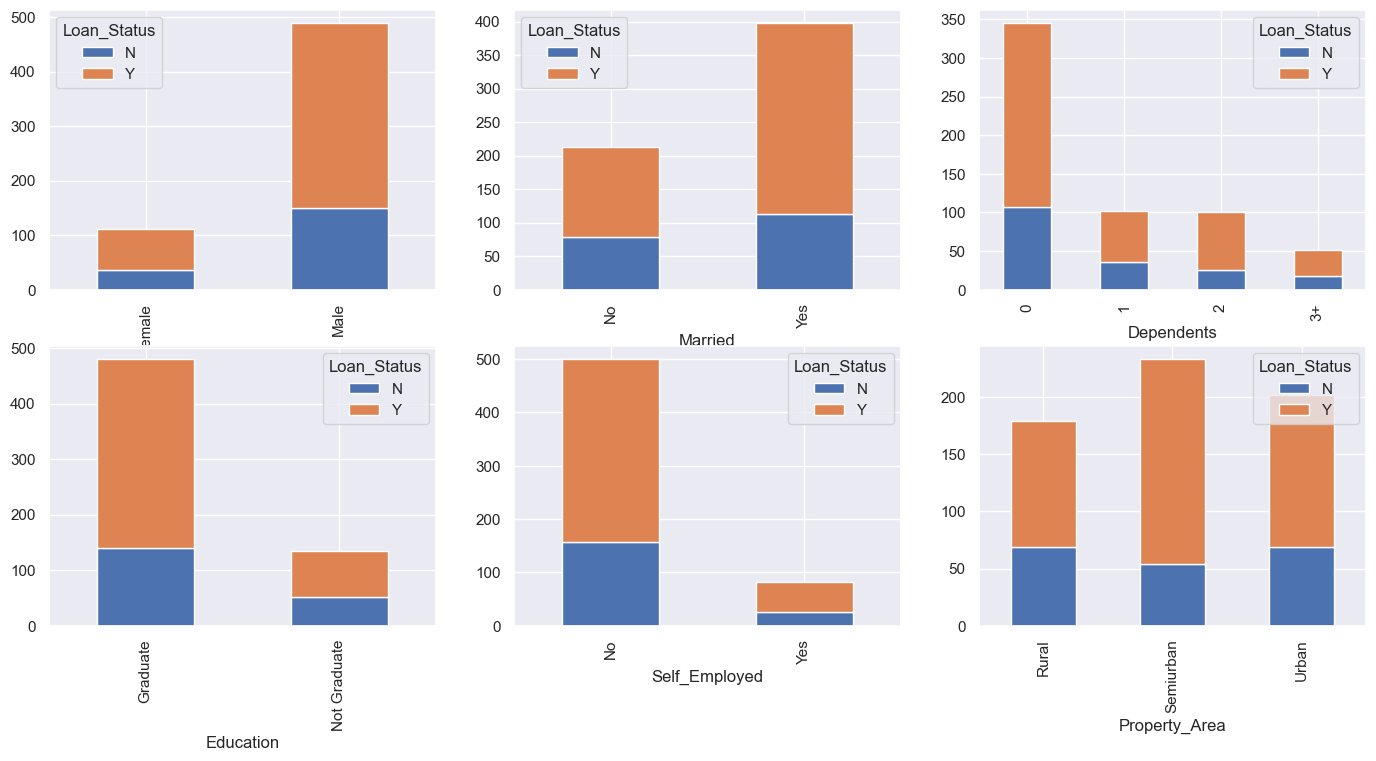

In [40]:
## Categorical  vs Target
fig, ax = plt.subplots(2,3, figsize=(17, 8))
pd.crosstab(loan["Gender"], loan["Loan_Status"]).plot(kind="bar", stacked=True, ax= ax[0,0])
pd.crosstab(loan["Married"], loan["Loan_Status"]).plot(kind="bar", stacked=True, ax= ax[0,1])
pd.crosstab(loan["Dependents"], loan["Loan_Status"]).plot(kind="bar", stacked=True, ax= ax[0,2])
pd.crosstab(loan["Education"], loan["Loan_Status"]).plot(kind="bar", stacked=True, ax= ax[1,0])
pd.crosstab(loan["Self_Employed"], loan["Loan_Status"]).plot(kind="bar", stacked=True, ax= ax[1,1])
pd.crosstab(loan["Property_Area"], loan["Loan_Status"]).plot(kind="bar", stacked=True, ax= ax[1,2])

C:\Users\EdwinVivekN\AppData\Local\Temp\ipykernel_21952\2613536458.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(loan["Loan_Status"], palette='hls', stat='percent')


<Axes: xlabel='percent', ylabel='Loan_Status'>

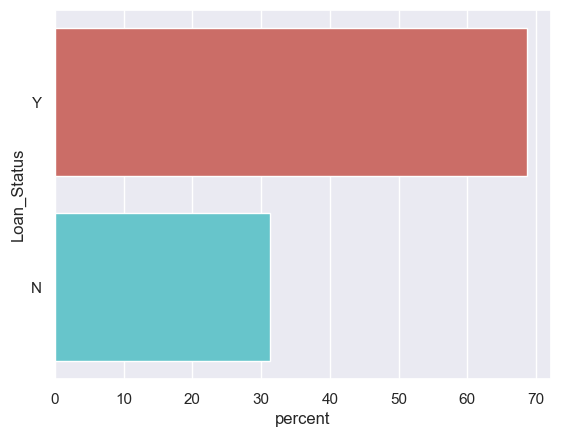

In [75]:
#check for imbalance class
sns.countplot(loan["Loan_Status"], palette='hls', stat='percent')

In [41]:
## Numerical Vs Target


## Logistic regression Model 

In [42]:
X = loan_final.loc[:, ~loan_final.columns.isin(["Loan_Status"])]
y = loan_final["Loan_Status"]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 20, stratify=y)

In [76]:
logistic = LogisticRegression(solver='liblinear', multi_class='ovr', class_weight='balanced')
logistic.fit(X_train, np.ravel(y_train))


C:\Users\EdwinVivekN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(class_weight='balanced', multi_class='ovr',
                   solver='liblinear')

In [77]:
coeff = pd.DataFrame(X_train.columns, columns=["Columns"])
coeff["Intercept"] = np.repeat(logistic.intercept_, coeff.shape[0])
coeff["Coefficients"] = pd.Series(logistic.coef_.ravel())
coeff['Odds ratio'] = pd.Series(np.exp(logistic.coef_.ravel()))  #exponent of coefficient is odds ratio
coeff

,Columns,Intercept,Coefficients,Odds ratio
0,ApplicantIncome,-0.649927,0.011547,1.011614
1,CoapplicantIncome,-0.649927,0.019145,1.019330
2,LoanAmount,-0.649927,-0.556861,0.573005
3,ohe__Gender_Male,-0.649927,-0.107413,0.898155
4,ohe__Married_Yes,-0.649927,0.615614,1.850793
5,ohe__Dependents_1,-0.649927,-0.632499,0.531262
6,ohe__Dependents_2,-0.649927,0.330233,1.391293
7,ohe__Dependents_3+,-0.649927,-0.091096,0.912930
8,ohe__Education_Not Graduate,-0.649927,-0.507528,0.601982
9,ohe__Self_Employed_Yes,-0.649927,0.072337,1.075017


In [78]:
print("Score:", logistic.score(X_train, y_train))
print("Actual iterations used:", logistic.n_iter_)

Score: 0.7678207739307535
Actual iterations used: [6]


In [79]:
y_train_pred = logistic.predict(X_train)
pred_proba = logistic.predict_proba(X_train)
pred_df = pd.DataFrame(pred_proba)
pred_df["Predictions"] = y_train_pred
pred_df["logit"] = np.log(pred_df[1]/ (1 - pred_df[1]))
pred_df

,0,1,Predictions,logit
0,0.343039,0.656961,Y,0.649779
1,0.251023,0.748977,Y,1.093164
2,0.641358,0.358642,N,-0.581264
3,0.142141,0.857859,Y,1.797618
4,0.474617,0.525383,Y,0.101618
...,...,...,...,...
486,0.578444,0.421556,N,-0.316388
487,0.522791,0.477209,N,-0.091225
488,0.411550,0.588450,Y,0.357562
489,0.327909,0.672091,Y,0.717660


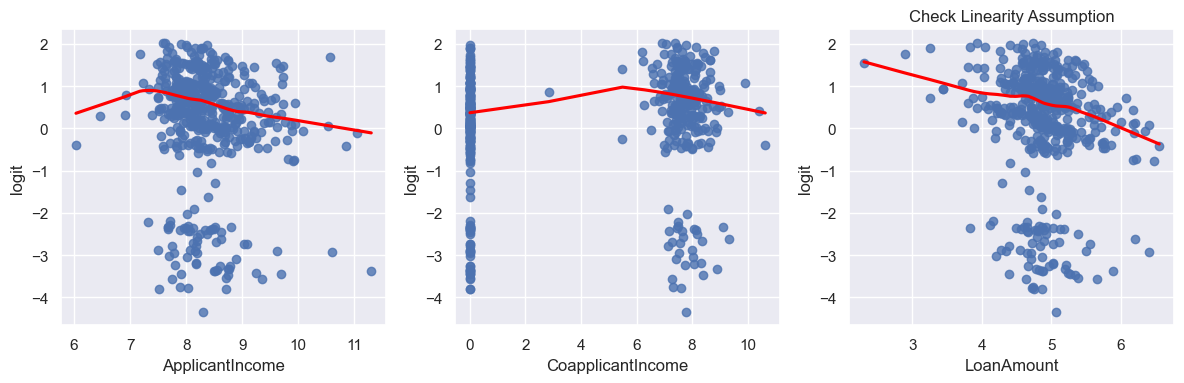

In [80]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
axes = axes.flat  
for i in range(3):
    ax = axes[i]
    #ax.plot([0, 1, 2], [i, i+1, i+2]) 
    sns.regplot(x=X_train.iloc[:,i], y=pred_df['logit'], lowess=True, line_kws={'color': 'red'}, ax =ax )
    #ax.set_title(f'Plot {i}')
    
plt.title("Check Linearity Assumption")
plt.tight_layout()

Text(0.5, 1.0, 'Confusion Matrix')

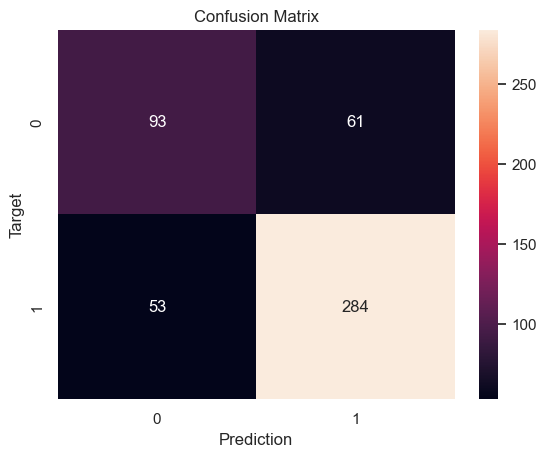

In [81]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_train, y_train_pred, labels=["N","Y"])
#pd.crosstab(y_train, y_train_pred)
plt.figure()
sns.heatmap(cf, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Target')
plt.title('Confusion Matrix')

In [82]:
from sklearn.metrics import classification_report
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           N       0.64      0.60      0.62       154
           Y       0.82      0.84      0.83       337

    accuracy                           0.77       491
   macro avg       0.73      0.72      0.73       491
weighted avg       0.76      0.77      0.77       491



In [83]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_train, y_train_pred, average=None)
print(precision)
recall = recall_score(y_train, y_train_pred, average=None)
print(recall)

[0.6369863  0.82318841]
[0.6038961  0.84272997]


In [84]:
#Log loss
from sklearn.metrics import log_loss
accuracy = log_loss(y_train, pred_proba)
print("Logloss: %.2f" % (accuracy))

Logloss: 0.49


In [85]:
#kappa score
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y_train, y_train_pred)

0.4530156744713286

0.8109368376430691
Best threshold: 0.4338968013601887


Text(0, 0.5, 'Sensitivity')

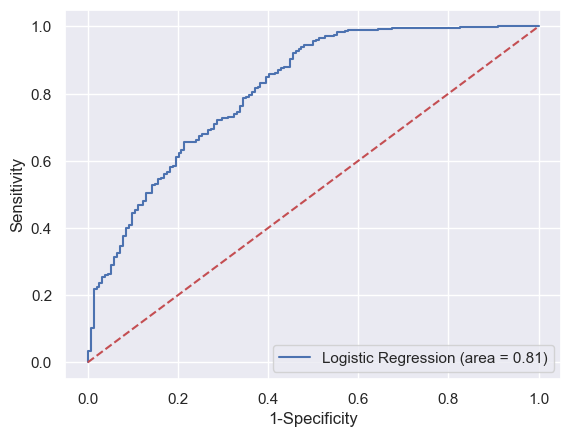

In [86]:
#ROC-AUC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_train,  pred_proba[:,1])
print(logit_roc_auc)
fpr, tpr, thresholds = roc_curve(y_train, pred_proba[:,1], pos_label="Y")

#Youden’s J statistic
youden_index = tpr - fpr  
best_threshold = thresholds[youden_index.argmax()] 
print(f"Best threshold: {best_threshold}")

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.legend(loc="lower right")
plt.xlabel("1-Specificity")
plt.ylabel("Sensitivity")

In [87]:
y_pred_final = (pred_df[1] >= best_threshold).astype(int)
y_pred_final = y_pred_final.map({1: "Y", 0: 'N'})  
# Evaluate the new predictions
from sklearn.metrics import classification_report
print(classification_report(y_train, y_pred_final))

              precision    recall  f1-score   support

           N       0.76      0.55      0.63       154
           Y       0.82      0.92      0.86       337

    accuracy                           0.80       491
   macro avg       0.79      0.73      0.75       491
weighted avg       0.80      0.80      0.79       491



Logistic: F1=0.833 PR AUC=0.888
Best PR threshold: 0.35669031593983536
Average precision-recall score: 0.89


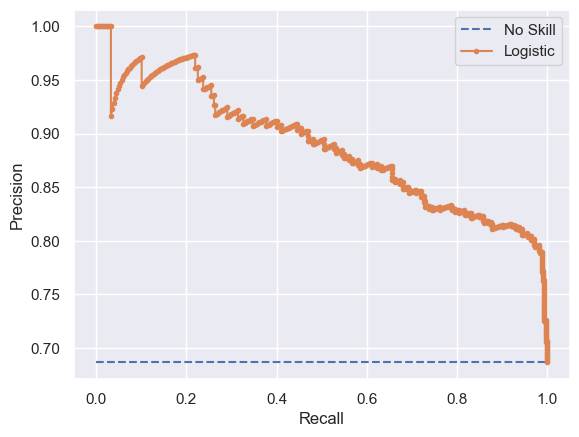

In [88]:
#PR curve
lr_precision, lr_recall, lr_thresholds = precision_recall_curve(y_train, pred_proba[:,1], pos_label="Y")
lr_f1= f1_score(y_train, y_train_pred, pos_label="Y")
lr_auc = auc(lr_recall, lr_precision)
print('Logistic: F1=%.3f PR AUC=%.3f' % (lr_f1, lr_auc))

f1_scores = (2 * lr_precision * lr_recall) / (lr_precision + lr_recall)
best_threshold = lr_thresholds[f1_scores.argmax()]
print(f"Best PR threshold: {best_threshold}")

no_skill = len(y_train[y_train == 'Y']) / len(y_train)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

from sklearn.metrics import average_precision_score
avg_precision = average_precision_score(y_train, pred_proba[:,1], pos_label="Y")
print('Average precision-recall score: {0:0.2f}'.format(
      avg_precision))

In [ ]:
import scikitplot as skplt 
skplt.metrics.plot_cumulative_gain(y_test, pred_proba)

In [ ]:
skplt.metrics.plot_lift_curve(y_test, pred_proba)
plt.legend(loc='best')

## Random Forest

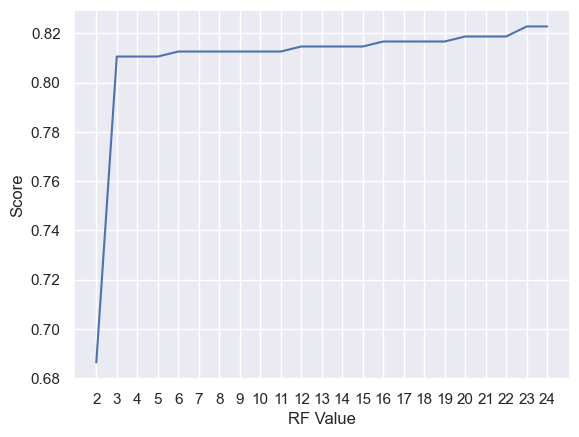

Random Forest Accuracy:  82.28%


In [100]:
from sklearn.ensemble import RandomForestClassifier
scoreListRF = []
for i in range(2,25):
    RFclassifier = RandomForestClassifier(n_estimators = 1000, random_state = 1, max_leaf_nodes=i)
    RFclassifier.fit(X_train, y_train)
    scoreListRF.append(RFclassifier.score(X_valid, y_valid))
    
plt.plot(range(2,25), scoreListRF)
plt.xticks(np.arange(2,25,1))
plt.xlabel("RF Value")
plt.ylabel("Score")
plt.show()
RFAcc = max(scoreListRF)
print("Random Forest Accuracy:  {:.2f}%".format(RFAcc*100))

In [ ]:
#chi square test for feature independence
from sklearn.feature_selection import chi2
chi_scores  = chi2(x_train, y_train)
chi_table = pd.DataFrame(x_train.columns)
chi_table['Chi Score'] = chi_scores[0]
chi_table['p-value'] = chi_scores[1]
print(chi_table)
p_values = pd.Series(chi_scores[1], index = x_train.columns)
p_values.sort_values(ascending = False , inplace = True)
p_values.plot.bar()

In [ ]:
#Recursive Feature Elimination
from sklearn.feature_selection import RFE
rfe = RFE(reg, n_features_to_select=5, step=1)
rfe = rfe.fit(x_train, y_train.values.ravel())
rfe_df = pd.DataFrame(x_train.columns)
rfe_df ["Support"] = pd.Series(rfe.support_)
rfe_df ["Ranking"] =  pd.Series(rfe.ranking_)
rfe_df
#remove features
#x_train = x_train[rfe_df[rfe_df['Support'] ==True][0]] 

# Test data validation


In [90]:
loan_test = pd.read_csv(os.path.abspath(os.path.join(os.getcwd(), 'data\\test_loanpred.csv')))
loan_test.shape

(367, 12)

In [91]:
loan_test.isna().sum().sort_values(ascending=False)

Credit_History       29
Self_Employed        23
Gender               11
Dependents           10
Loan_Amount_Term      6
LoanAmount            5
Loan_ID               0
Married               0
Education             0
ApplicantIncome       0
CoapplicantIncome     0
Property_Area         0
dtype: int64

In [92]:
loan_test.drop(columns=['Loan_ID'], axis=1, inplace=True)
loan["Loan_Amount_Term"] = loan["Loan_Amount_Term"].astype('category')

In [93]:
numeric_test_transformed = numeric_transforms.transform(loan_test[numeric_cols])
numeric_test_transformed_df = pd.DataFrame(numeric_test_transformed, columns=numeric_cols, index=loan_test.index)

cat_test_transformed = cat_encode.transform(loan_test[cat_cols])
cat_test_transformed_df = pd.DataFrame(cat_test_transformed, columns=cat_encode.named_steps["one_hot"].get_feature_names_out(), index=loan_test.index)

binary_test_transformed = binary_impute.transform(loan_test)
binary_test_transformed_df = pd.DataFrame(binary_test_transformed, columns=binary_impute.get_feature_names_out())

loan_test_final = loan_test.drop(columns=drop_cols).join(numeric_test_transformed_df).join(cat_test_transformed_df).join(binary_test_transformed_df)
loan_test_final

,ApplicantIncome,CoapplicantIncome,LoanAmount,ohe__Gender_Male,ohe__Married_Yes,ohe__Dependents_1,ohe__Dependents_2,ohe__Dependents_3+,ohe__Education_Not Graduate,ohe__Self_Employed_Yes,ohe__Loan_Amount_Term_Medium,ohe__Loan_Amount_Term_Short,ohe__Property_Area_Semiurban,ohe__Property_Area_Urban,credit_hist__Credit_History
0,8.651899,0.000000,4.709530,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,8.031710,7.313887,4.844187,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,8.517393,7.496097,5.342334,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,7.758333,7.842671,4.615121,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,8.094684,0.000000,4.369448,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,8.296547,7.483244,4.736198,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
363,8.333030,6.565265,4.753590,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
364,8.086718,7.597898,4.844187,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
365,8.517393,7.780721,5.068904,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [94]:
loan_test_final.isna().sum()

ApplicantIncome                 0
CoapplicantIncome               0
LoanAmount                      0
ohe__Gender_Male                0
ohe__Married_Yes                0
ohe__Dependents_1               0
ohe__Dependents_2               0
ohe__Dependents_3+              0
ohe__Education_Not Graduate     0
ohe__Self_Employed_Yes          0
ohe__Loan_Amount_Term_Medium    0
ohe__Loan_Amount_Term_Short     0
ohe__Property_Area_Semiurban    0
ohe__Property_Area_Urban        0
credit_hist__Credit_History     0
dtype: int64

In [96]:
logistic.predict(loan_test_final)

array(['Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'N', 'Y', 'Y', 'N', 'Y', 'Y',
       'N', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'N',
       'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'N', 'N', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'N', 'Y',
       'Y', 'N', 'N', 'Y', 'N', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y',
       'Y', 'Y', 'N', 'Y', 'N', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'N', 'Y',
       'N', 'Y', 'Y', 'N', 'Y', 'N', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'Y',
       'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
       'N', 'N', 'N', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'N', 'Y', 'Y', 'Y',
       'Y', 'N', 'Y', 'N', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'N',
       'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'N', 'N', 'Y', 'N', 'N', 'Y', 'Y',
       'Y', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'Y', 'N', 'N', 'N', 'Y', 'N',
       'Y', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y

In [ ]:
#Equivalent to the predict_proba method in sklearn
from scipy.special import expit
predict_proba_1 = expit(np.dot(X_train, logistic.coef_.ravel()) + logistic.intercept_)  #The expit function, also known as the logistic sigmoid function, is defined as expit(x) = 1/(1+exp(-x)). It is the inverse of the logit function.


In [ ]:
#Equivalent to sklearn Logistic regression model
import statsmodels.api as sm
X_train_const = sm.add_constant(X_train)
y_train_mapped = y_train.map({'Y': 1, 'N': 0})  
logit_model= sm.Logit(y_train_mapped, X_train_const).fit()
print(logit_model.summary())

In [ ]:
X_train_const.isna().sum()